In [1]:
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline

from __future__ import print_function
from copy import deepcopy
import math
import matplotlib.pyplot as plt
import numpy as np
import pydrake
import os
import sys
import time
from torchviz import make_dot

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.probabilistic_scene_grammar_nodes import *
from scene_generation.models.probabilistic_scene_grammar_model import *
from scene_generation.models.probabilistic_scene_grammar_fitting import *

In [2]:
seed = 47
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.enable_validation(True)
pyro.clear_param_store()

/home/gizatt/projects/scene_generation/models/probabilistic_scene_grammar_nodes.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.production_dist.log_prob(torch.tensor(selected_rules)).sum()
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


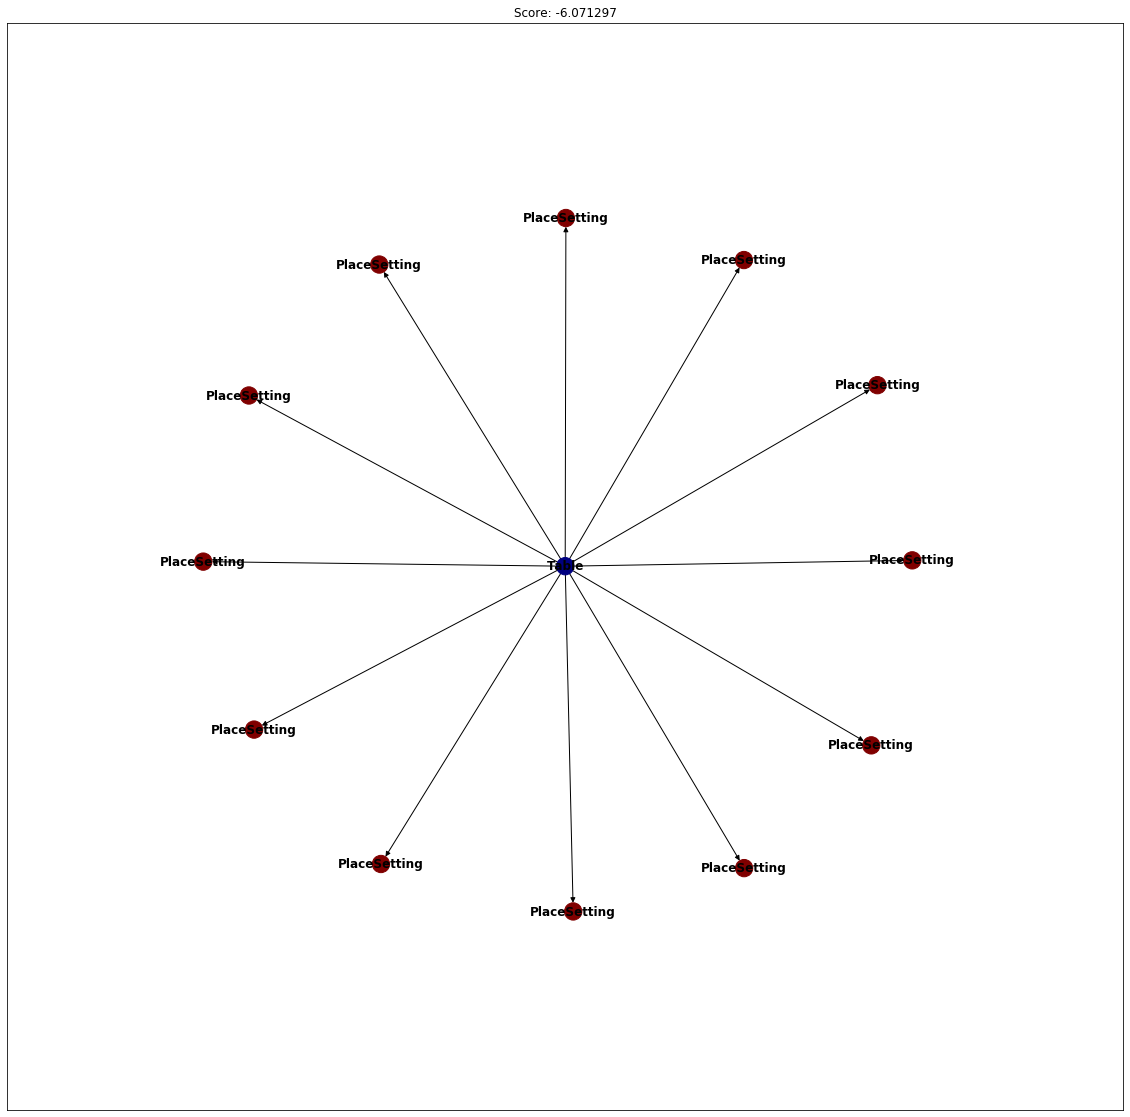

In [3]:
plt.figure().set_size_inches(20, 20)
hyper_parse_tree = generate_hyperexpanded_parse_tree()
draw_parse_tree(hyper_parse_tree, label_name=True, label_score=False)

/home/gizatt/underactuated/src/underactuated/multibody.py:2: DrakeDeprecationWarning: This module is deprecated and will be removed on or around 2019-10-01. Please use 'pydrake.attic.multibody.rigid_body_tree' instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  from pydrake.multibody.rigid_body_tree import *
/home/gizatt/projects/scene_generation/models/probabilistic_scene_grammar_nodes.py:249: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.production_dist.log_prob(torch.tensor(selected_rules)).sum()
/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/gizatt/miniconda3/envs/py

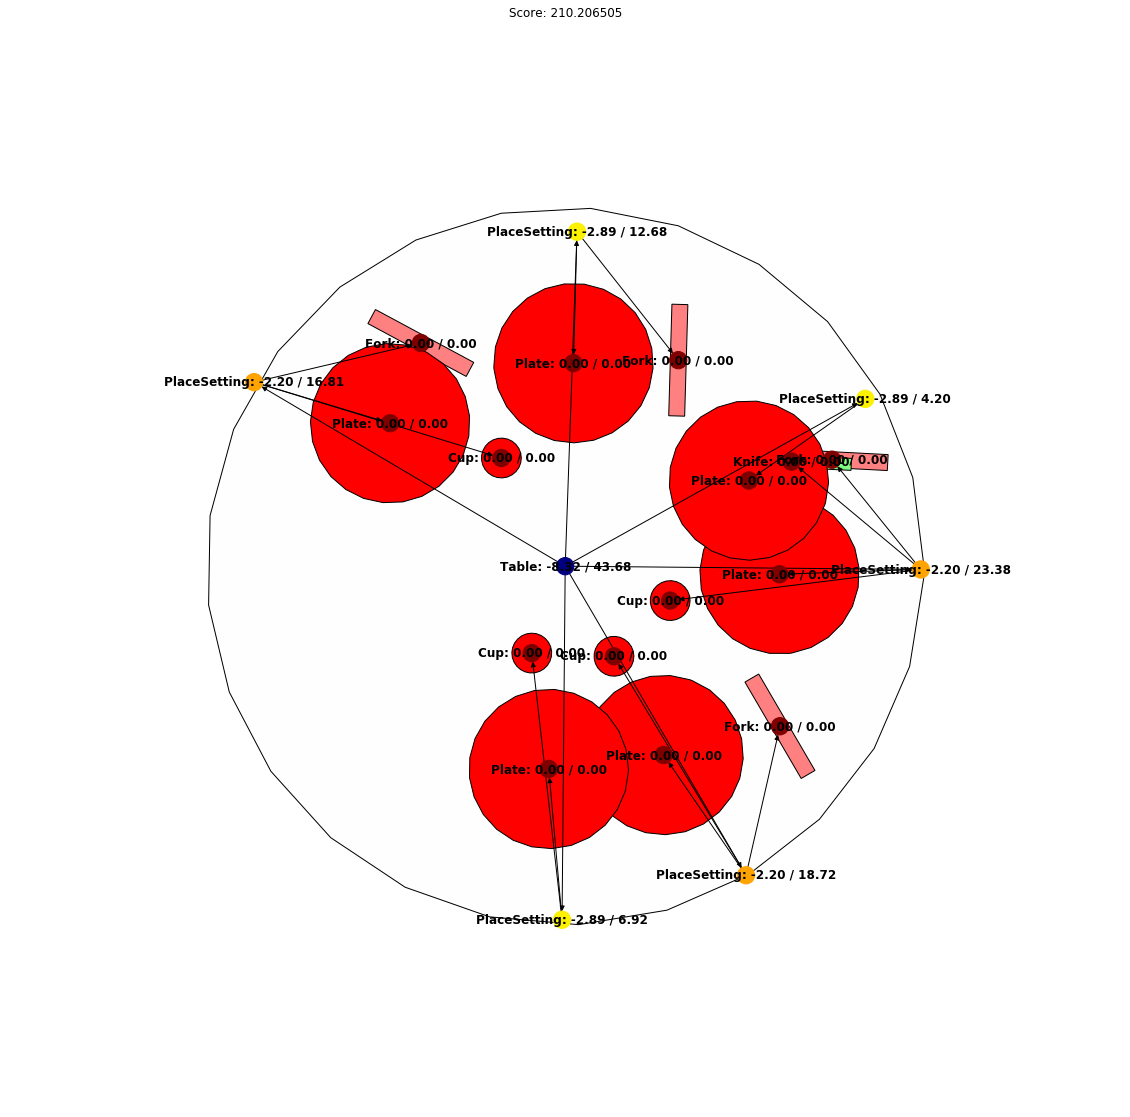

In [4]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
trace = poutine.trace(generate_unconditioned_parse_tree).get_trace()
parse_tree = trace.nodes["_RETURN"]["value"]        
score = trace.log_prob_sum()
yaml_env = convert_tree_to_yaml_env(parse_tree)
DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
draw_parse_tree(parse_tree, label_name=True, label_score=True)

def print_param_store(grads=False):
    for param_name in pyro.get_param_store().keys():
        val = pyro.param(param_name)#.tolist()
        grad = pyro.param(param_name).grad
        #if isinstance(val, float):
        #    val = [val]
        if grads:
            print(param_name, ": ", val.data, ", unconstrained grad: ", pyro.get_param_store()._params[param_name].grad)
        else:
            print(param_name, ": ", val.data)

In [5]:
train_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_nominal_train")
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_nominal_test")

print("%d training examples" % len(train_dataset))
print("%d test examples" % len(test_dataset))

400 training examples
99 test examples


In [6]:
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml
from tensorboardX import SummaryWriter
import datetime

log_dir = "/home/gizatt/projects/scene_generation/models/runs/psg/table_setting/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)

# Initialize the guide GVS as mean field
guide_gvs = hyper_parse_tree.get_global_variable_store()
# Note -- if any terminal nodes have global variables associated with
# them, they won't be in the guide.
for var_name in guide_gvs.keys():
    guide_gvs[var_name][0] = pyro.param(var_name + "_est",
                                        guide_gvs[var_name][0],
                                        constraint=guide_gvs[var_name][1].support)

# setup the optimizer
adam_params = {"lr": 0.025, "betas": (0.8, 0.95)}
optimizer = Adam(adam_params)

baseline = 0.
    
param_val_history = []
score_history = []
score_test_history = []

# do gradient steps
print_param_store()
if len(score_history) > 0:
    best_loss_yet = min(score_history)
else:
    best_loss_yet = np.infty

snapshots = {}
    
for step in range(100):
    # Pick a few random environment and parse them
    loss, active_param_names = score_subset_of_dataset(train_dataset, n=2, guide_gvs=guide_gvs)
    writer.add_scalar('loss', loss.item(), step)

    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    optimizer(params)

    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    print("Loss: ", loss)
    #loss = svi.step(observed_tree)
    score_history.append(loss)
    
    if (step % 5 == 0):
        # Evaluate on a few test data points
        loss_test, _ = score_subset_of_dataset(test_dataset, n=2, guide_gvs=guide_gvs)
        score_test_history.append(loss_test)
        writer.add_scalar('loss_test', loss_test.item(), step)
        print("Loss_test: ", loss_test)

        if loss_test < best_loss_yet:
            best_loss_yet = loss
            pyro.get_param_store().save("best_on_test_save.pyro")
            
        # Also generate a few example environments
        # Generate a ground truth test environment
        plt.figure().set_size_inches(20, 20)
        for k in range(4):
            plt.subplot(2, 2, k+1)
            parse_tree = generate_unconditioned_parse_tree(initial_gvs=guide_gvs)
            yaml_env = convert_tree_to_yaml_env(parse_tree)
            try:
                DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
            except:
                print("Unhandled exception in drawing yaml env")
            draw_parse_tree(parse_tree, label_name=True, label_score=True)
        writer.add_figure("generated_envs", plt.gcf(), step, close=True)

    all_param_state = {name: pyro.param(name).detach().cpu().numpy().copy() for name in pyro.get_param_store().keys()}
    for param_name in all_param_state.keys():
        write_np_array(writer, param_name, all_param_state[param_name], step)
    param_val_history.append(all_param_state)
    #print("Place setting plate mean mean: ", pyro.param("place_setting_plate_mean_mean"))
    #print("Place setting plate var: ", pyro.param("place_setting_plate_mean_var"))
print("Final loss: ", loss)
print_param_store()

table_production_weights :  tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002])
place_setting_production_weights :  tensor([0.0006, 0.0556, 0.0278, 0.0556, 0.0006, 0.0556, 0.0006, 0.1113, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.1113, 0.0006, 0.1113,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.1113,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0

Obs tree with joint score 22.678310, latents score 17.969102, total score -22.678310
Loss:  -78.15873949108206
Obs tree with joint score -615.164183, latents score -205.450944, total score 615.164183
Obs tree with joint score 128.693337, latents score 120.277959, total score -128.693337
Loss:  243.2354230833815
Obs tree with joint score -7.564068, latents score -7.564068, total score 7.564068
Obs tree with joint score -137.712214, latents score 28.027861, total score 137.712214
Loss_test:  tensor(72.6381, grad_fn=<MeanBackward0>)
Obs tree with joint score -1283.274101, latents score -643.577758, total score 1283.274101
Obs tree with joint score 63.415186, latents score 49.872008, total score -63.415186
Loss:  609.9294577574678
Obs tree with joint score -789.121181, latents score -351.451324, total score 789.121181
Obs tree with joint score -7.534548, latents score -7.534548, total score 7.534548
Loss:  398.32786443049287
Obs tree with joint score -4447.351638, latents score -1211.36376

Obs tree with joint score -6.594328, latents score -6.594328, total score 6.594328
Obs tree with joint score 78.216528, latents score 60.496923, total score -78.216528
Loss:  -35.81110003955626
Obs tree with joint score -290.535872, latents score 101.188177, total score 290.535872
Obs tree with joint score -9027.448796, latents score -285.792859, total score 9027.448796
Loss:  4658.992334142149
Obs tree with joint score -660.716751, latents score -198.846974, total score 660.716751
Obs tree with joint score 102.281025, latents score 90.222571, total score -102.281025
Loss:  279.21786275945624
Obs tree with joint score 37.268092, latents score 27.178467, total score -37.268092
Obs tree with joint score -5444.081947, latents score -417.344754, total score 5444.081947
Loss_test:  tensor(2703.4069, grad_fn=<MeanBackward0>)
Obs tree with joint score -83.971188, latents score 39.730099, total score 83.971188
Obs tree with joint score 23.045993, latents score 31.821968, total score -23.045993

Obs tree with joint score -254.733408, latents score 53.469200, total score 254.733408
Obs tree with joint score -1049.500399, latents score -648.586325, total score 1049.500399
Loss:  652.1169031760353
Obs tree with joint score -134.659375, latents score 1.307340, total score 134.659375
Obs tree with joint score -349.874927, latents score -306.738327, total score 349.874927
Loss:  242.26715088595574
Obs tree with joint score 6.657690, latents score 58.538537, total score -6.657690
Obs tree with joint score -397.493323, latents score -322.497155, total score 397.493323
Loss:  195.417816592075
Obs tree with joint score -906.042302, latents score -530.787427, total score 906.042302
Obs tree with joint score -149.990223, latents score 12.688674, total score 149.990223
Loss:  528.0162624428469
Obs tree with joint score -1852.103146, latents score -915.498982, total score 1852.103146
Obs tree with joint score -3880.645265, latents score -302.705051, total score 3880.645265
Loss:  2866.37420

KeyboardInterrupt: 

In [ ]:
scores_over_time_adjusted = np.array(score_history)
max_score = np.max(scores_over_time_adjusted)
#scores_over_time_adjusted = np.log(scores_over_time_adjusted - min_score + 1.)
plt.plot(score_history)
plt.title("Score history (initial %f, best %f)" % (score_history[0], max_score))
plt.ylabel("ll")
plt.xlabel("Epoch")
plt.ylim(max_score - 2000, max_score + 10)
print(pyro.get_param_store().get_all_param_names())
names_of_interest = ["place_setting_plate_mean", "place_setting_plate_var", 
                     "place_setting_left_fork_mean", "place_setting_left_fork_var",
                     "place_setting_right_fork_mean", "place_setting_right_fork_var",
                     #"place_setting_left_spoon_mean", "place_setting_left_spoon_var",
                     #"place_setting_right_spoon_mean", "place_setting_right_spoon_var",
                     "place_setting_cup_mean", "place_setting_cup_var",
                     #"place_setting_production_weights",
                     "table_independent_set_production_probs"]
plt.figure().set_size_inches(30, 30)
for i, name in enumerate(names_of_interest):
    val_epochs = [k for k, d in enumerate(param_val_history) if name in d.keys()]
    vals_across_time = np.vstack([d[name] for d in param_val_history if name in d.keys()]).T
    print(vals_across_time.shape)
    num_vals = vals_across_time.shape[0]
    for j in range(num_vals):
        plt.subplot(len(names_of_interest), num_vals, i*num_vals + j + 1)
        plt.plot(val_epochs, vals_across_time[j, :])
        plt.ylabel(name + "[%d]" % j)
        plt.xlabel("epoch")
#plt.tight_layout()

In [ ]:
import scene_generation.data.dataset_utils as dataset_utils

# Score the outlier dataset
outlier_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_generated_with_left_knife_and_spoon_rules.yaml")
scores_outlier = []
observed_trees_outlier = []
for i, env in enumerate(outlier_dataset):
    observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
    observed_trees_outlier.append(observed_tree)
    scores_outlier.append(joint_score.item())
    print("Scored outlier %d at %f" % (i, joint_score))
    
# Score the test dataset
test_dataset = dataset_utils.ScenesDataset("../data/table_setting/table_setting_environments_nominal_test")
scores_test = []
observed_trees_test = []
for i, env in enumerate(test_dataset):
    observed_tree, joint_score = guess_parse_tree_from_yaml(env, outer_iterations=1, num_attempts=2)
    observed_trees_test.append(observed_tree)
    scores_test.append(joint_score.item())
    print("Scored test %d at %f" % (i, joint_score))

In [ ]:
# Sort
inds_in_ascending_order = np.argsort(scores_outlier)

plt.figure().set_size_inches(6, 3)
bins = np.arange(min(np.min(scores_outlier), np.min(scores_test)),
                 max(np.max(scores_outlier), np.max(scores_test)), 20)
plt.hist(scores_test, normed=True, bins=10, label="test", alpha=0.75)
plt.hist(scores_ascending, normed=True, bins=20, label="outliers", alpha=0.75)
plt.title("Score histogram across example")
plt.ylabel("Ratio")
plt.xlabel("LL")
plt.legend()

plt.figure().set_size_inches(20, 20)
for i in range(3):
    for j in range(3):
        ind = i*3 + j
        plt.subplot(3, 3, ind + 1)
        ind_into_orig = inds_in_ascending_order[ind]
        plt.title("Score %f" % scores_outlier[ind_into_orig])
        DrawYamlEnvironmentPlanar(outlier_dataset[ind_into_orig], base_environment_type="table_setting", ax=plt.gca())
        draw_parse_tree(observed_trees_outlier[ind_into_orig], label_name=True, label_score=True)

In [ ]:
# Generate a ground truth test environment
plt.figure().set_size_inches(20, 20)
images = []
for k in range(10):
    plt.gca().clear()
    trace = poutine.trace(generate_unconditioned_parse_tree).get_trace(guide_gvs)
    parse_tree = trace.nodes["_RETURN"]["value"]        
    score = trace.log_prob_sum()
    yaml_env = convert_tree_to_yaml_env(parse_tree)
    try:
        DrawYamlEnvironmentPlanar(yaml_env, base_environment_type="table_setting", ax=plt.gca())
    except:
        print("Unhandled exception in drawyamlenv")
    #draw_parse_tree(parse_tree, label_name=False, label_score=False)
    plt.title("")
    plt.gca().axis('off')
    images.append(dataset_utils.fig2data(plt.gcf()).copy())
plt.gca().clear()
for im in images:
    plt.imshow(im, alpha=0.25)
plt.gca().axis('off')
plt.show()

In [ ]:
# Generate a bunch of envs + their parse trees
generated_envs_and_trees = []
for k in range(100):
    parse_tree = generate_unconditioned_parse_tree()
    generated_envs_and_trees.append((
        convert_tree_to_yaml_env(parse_tree),
        parse_tree))

In [ ]:
# Instead train on environments in which I have perfect parse trees
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import yaml

# setup the optimizer
adam_params = {"lr": 0.01, "betas": (0.5, 0.5)}
optimizer = Adam(adam_params)
    
pyro.param("place_setting_left_fork_mean").data[0] = 0.0
# do gradient steps
print_param_store()
for step in range(100):
    # Pick a few random environment and parse them
    losses = []
    active_param_names = set()
    random.shuffle(generated_envs_and_trees)
    for env, best_observed_tree in generated_envs_and_trees[:5]:
        best_score, _ = score_tree(best_observed_tree)
        losses.append(-1. * best_score)
        active_param_names = set().union(active_param_names,
            *[node.get_param_names() for node in best_observed_tree.nodes])
    loss = torch.stack(losses).mean()
    #active_param_names = ["place_setting_left_fork_mean"]
    params = set(pyro.get_param_store()._params[name] for name in active_param_names)
    pyro.infer.util.zero_grads(params)
    loss.backward(retain_graph=True)
    #print("Val: ", pyro.param("place_setting_left_fork_mean").detach().cpu().numpy())
    #print("Grad: ", pyro.get_param_store()._params["place_setting_left_fork_mean"].grad)
    #for param in params:
    #   param.data + param.grad*100
    optimizer(params)
    # zero gradients
    pyro.infer.util.zero_grads(params)
    loss = pyro.infer.util.torch_item(loss)
    #loss = svi.step(observed_tree)
    print("Loss: ", loss)
    #print("Place setting plate mean: ", pyro.param("place_setting_plate_mean"))
    #print("Place setting plate var: ", pyro.param("place_setting_plate_var"))
print("Final loss: ", loss)
print_param_store()

In [ ]:
pyro.get_param_store()._params["place_setting_left_fork_var"]

In [ ]:
from matplotlib.patches import Ellipse

# Get offsets of each object class from each place setting
offsets_by_class = {}
scores_by_class = {}
gt_by_class = {}
for observed_env, observed_tree in generated_envs_and_trees:
    score, _ = score_tree(observed_tree)
    for node in observed_tree.nodes:
        if isinstance(node, PlaceSetting.ObjectProductionRule):
            child_class = node.object_name
            if child_class not in offsets_by_class.keys():
                offsets_by_class[child_class] = []
                gt_by_class[child_class] = node.offset_dist
                scores_by_class[child_class] = []
            parent = get_node_parent_or_none(observed_tree, node)
            assert(parent)
            child = list(observed_tree.successors(node))[0]
            offsets_by_class[child_class].append(
                node._recover_rel_pose_from_abs_pose(parent, child.pose).detach().numpy().copy())
            scores_by_class[child_class].append(score.item())
                                                     
plt.figure()
n_classes = len(offsets_by_class.keys())
for k, class_name in enumerate(offsets_by_class.keys()):
    plt.subplot(1, n_classes, k+1)
    plt.title(class_name)
    pts = np.vstack(offsets_by_class[class_name]).T
    plt.scatter(pts[0, :], pts[1, :], c=scores_by_class[class_name], alpha=0.25)
    
    gt_mean = gt_by_class[class_name].mean.detach().numpy().copy()
    gt_std = np.sqrt(gt_by_class[class_name].variance.detach().numpy().copy())
    ell = Ellipse(xy=gt_mean[:2],
                  width=gt_std[0]*3, height=gt_std[1]*3)
    ell.set_color('red')
    ell.set_facecolor('none')
    plt.gca().add_artist(ell)
    plt.xlim(gt_mean[0]-0.2, gt_mean[0]+0.2)
    plt.ylim(gt_mean[1]-0.2, gt_mean[1]+0.2)
    

plt.tight_layout()